# Categorical Structured Data Logistic and Linear Regression with TF Keras

[Link to dataset source](https://archive.ics.uci.edu/dataset/10/automobile)

[Link to Colab (deprecated)](https://colab.research.google.com/drive/1GmAhxnKVvrhWffospDEe0rc-QB_tjfhE?usp=sharing)

# Inits

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pathlib import Path

from src.custom_types import TypeEnum
from src.tf_layer_constructors import (
    gen_normalization_layer,
    gen_multihot_categorical_encoding_layer
)
from src.tf_utils import df_to_tfds
from src.data_examples.ex1_data_loader import ExampleDataLoader

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


In [2]:
RAND_SEED = 1337

np.random.seed(RAND_SEED)
random.seed(RAND_SEED)
np.set_printoptions(precision=3, suppress=True)

tf.keras.backend.clear_session()

mae = tf.keras.metrics.MeanAbsoluteError()
mse = tf.keras.metrics.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()

evaluation_metrics_dict = {
  'mae': mae,
  'mse': mse,
  'rmse': rmse,
}

In [3]:
def eval_metrics(model, tsdf_test, metrics={}):
  ret = {}
  for x_test, y_test in tfds_test:
    y_pred = loaded_model.predict(x_test)
    for metric_name, metric in metrics.items():
      metric.update_state(y_test, y_pred)

  for metric_name, metric in metrics.items():
    ret[metric_name] = metric.result().numpy()
    metric.reset_states()

  return ret

In [4]:
saved_model_path = Path('saved_models')
saved_model_path.mkdir(exist_ok=True)

## Loading Example Data

Within this repository, data loader is used more-or-less to standardize dataset into a dataframe and store various metadata of the dataset themself. This approach is done because unfamiliarity of the given data source.

There are few things to note:
  - data loader performs unified procedures to prepare and clean dataset. Head over to `data_examples/ex1_data_loader.py` to customize the required procedures.
  - data loader have the following attributes which we can fetch:
    - `.feature_label` which holds the feature label string representation of the dataset
    - `.features_*` which holds list of features of the structured categorical data, namely `features_categorical` and `features_numeric_continuous` to determine preprocessing input layers
    - `.data_spec` holds the meta of the dataset, whether it's categorical denoted by list of items, and range of continuous number denoted by tuple
    - `.df` which holds the pandas dataframe
    - these attributes later be used to infer preprocessing layer and training
  - data loader have the following method which we can call:
    - .download() to download the data
    - .load() to load the data into `__instance__.df` pandas dataframe
    - .clean() to perform cleaning
    - .drop_unused() to drop unused features from the dataframe table
  - in context of federated learning, this loader hopefully can be used as a base class from which can be delegated to cluster of clients to fetch data

In [5]:
data = ExampleDataLoader()

data.download().load().clean()
data.df.info()

using cached file cache\static\public\10\automobile.zip
extracting zip file content:
 	size: 144	filename: Index
 	size: 1197	filename: app.css
 	size: 25936	filename: imports-85.data
 	size: 4747	filename: imports-85.names
 	size: 3757	filename: misc
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          159 non-null    int32  
 1   normalized_losses  159 non-null    float32
 2   make               159 non-null    string 
 3   fuel_type          159 non-null    string 
 4   aspiration         159 non-null    string 
 5   num_of_doors       159 non-null    string 
 6   body_style         159 non-null    string 
 7   drive_wheels       159 non-null    string 
 8   engine_location    159 non-null    string 
 9   wheel_base         159 non-null    float32
 10  length             159 non-null    float32
 11  width         

For binary classification, `symboling_threshold` is used to override label feature from initial `symboling` label   

In [6]:
data.df['symboling_threshold'] = [1 if i > 0 else 0 for i in data.df['symboling']]

target_feature_label = 'symboling_threshold'

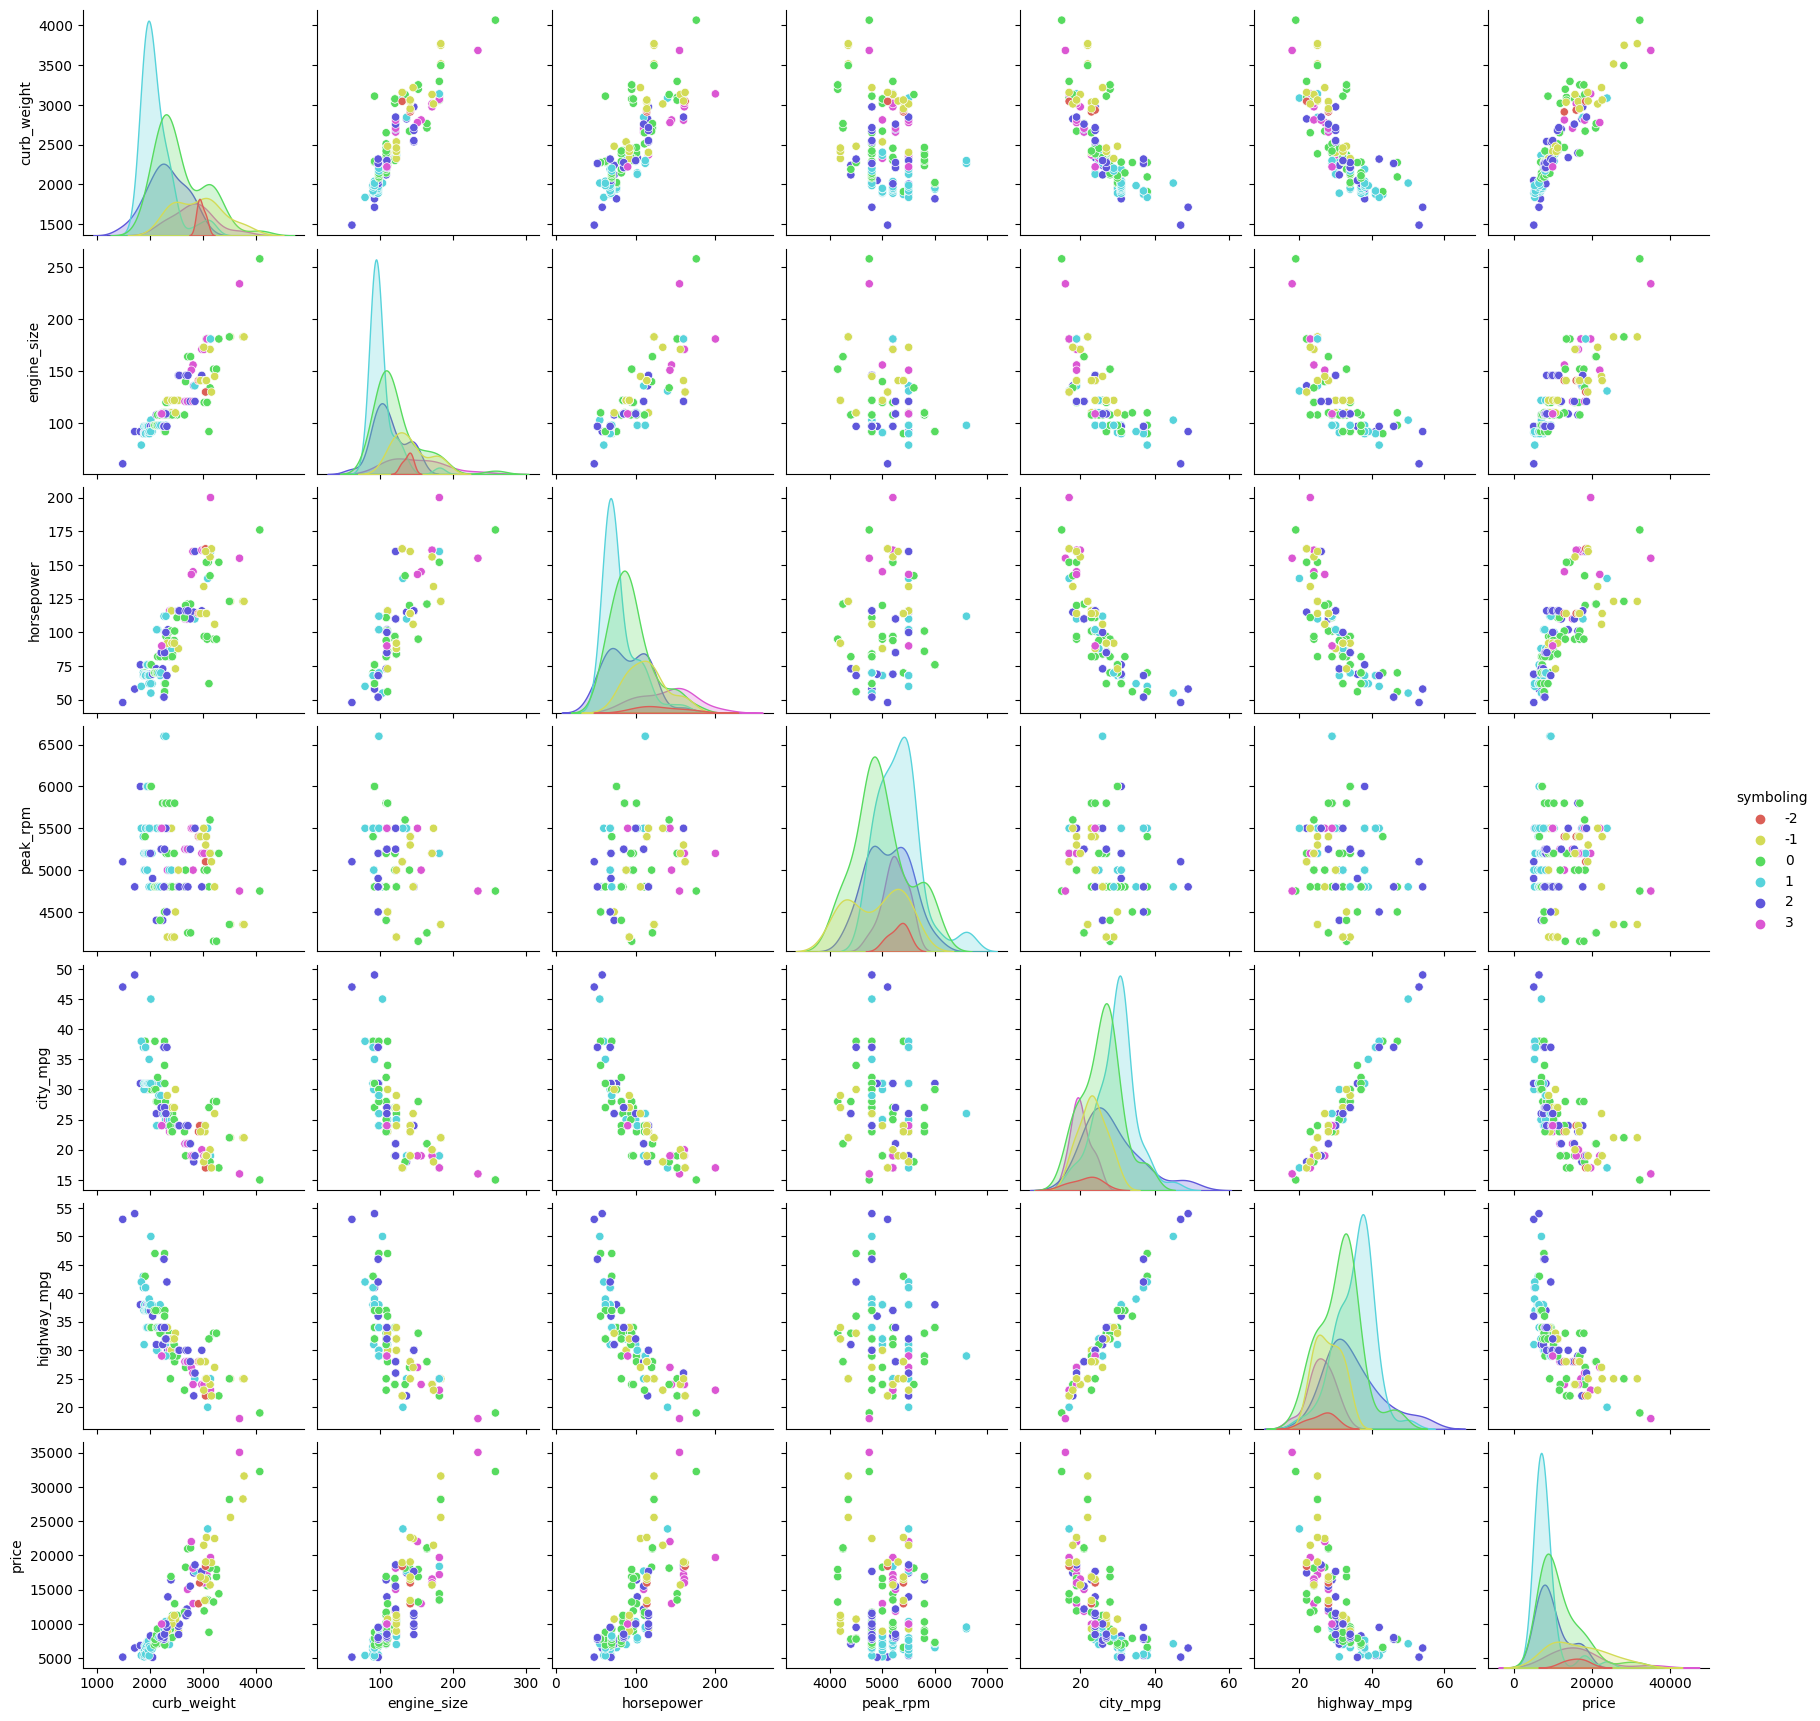

In [7]:
# Pairplot of a know dataset numerical features correlation to our initial feature label

sns.pairplot(
  data.df[
    [
      data.feature_label,
      "curb_weight",
      "engine_size",
      "horsepower",
      "peak_rpm",
      "city_mpg",
      "highway_mpg",
      "price"
    ]
  ], diag_kind='kde', hue=data.feature_label, palette=sns.color_palette('hls', len(data.df[data.feature_label].unique())))

to drop features from data loader, override corresponding feature list from the loader instance as follows

In [8]:
# in this example, commented out features are dropped

data.features_numeric_continuous = [    
  'wheel_base',
  'length',
  'width',
  'height',
  'curb_weight',
  'engine_size',
  # 'bore',
  # 'stroke',
  # 'compression_ratio',
  'horsepower',
  # 'peak_rpm',
  'city_mpg',
  'highway_mpg',
  'price'
]

# to drop commented out features, call the drop_unused() method

data.drop_unused()

Inspect the dataframe table

In [9]:
data.df

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,horsepower,city_mpg,highway_mpg,price,symboling_threshold
3,2,audi,gas,std,four,sedan,fwd,front,99.800003,176.600006,...,2337.0,ohc,four,109.0,mpfi,102.0,24.0,30.0,13950.0,1
4,2,audi,gas,std,four,sedan,4wd,front,99.400002,176.600006,...,2824.0,ohc,five,136.0,mpfi,115.0,18.0,22.0,17450.0,1
6,1,audi,gas,std,four,sedan,fwd,front,105.800003,192.699997,...,2844.0,ohc,five,136.0,mpfi,110.0,19.0,25.0,17710.0,1
8,1,audi,gas,turbo,four,sedan,fwd,front,105.800003,192.699997,...,3086.0,ohc,five,131.0,mpfi,140.0,17.0,20.0,23875.0,1
10,2,bmw,gas,std,two,sedan,rwd,front,101.199997,176.800003,...,2395.0,ohc,four,108.0,mpfi,101.0,23.0,29.0,16430.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,volvo,gas,std,four,sedan,rwd,front,109.099998,188.800003,...,2952.0,ohc,four,141.0,mpfi,114.0,23.0,28.0,16845.0,0
201,-1,volvo,gas,turbo,four,sedan,rwd,front,109.099998,188.800003,...,3049.0,ohc,four,141.0,mpfi,160.0,19.0,25.0,19045.0,0
202,-1,volvo,gas,std,four,sedan,rwd,front,109.099998,188.800003,...,3012.0,ohcv,six,173.0,mpfi,134.0,18.0,23.0,21485.0,0
203,-1,volvo,diesel,turbo,four,sedan,rwd,front,109.099998,188.800003,...,3217.0,ohc,six,145.0,idi,106.0,26.0,27.0,22470.0,0


In [10]:
# from the notion above, we can create sample generator from data_spec data loader attr

def generate_random_sample_from_spec(data_spec, features_override=[]):
  ret = {}
  for k in data_spec.keys():
    if features_override and k not in features_override:
      continue
    v = data_spec.get(k)
    if isinstance(v, tuple):
      ret[k] = random.random() * (v[1] - v[0])
    elif isinstance(v, list):
      ret[k] = random.choice(v)
    else:
      ret[k] = v
  return ret

In [11]:
__inference_features = data.features_categorical + data.features_numeric_continuous

# a little bit of cleaning since the loader renamed all features, skip this process if you exclude renaming from the cleaning procedure
__inference_features = list(map(lambda x: x.replace('_', '-'), __inference_features))

print('training features', __inference_features)

__inference_sample = generate_random_sample_from_spec(data.data_spec, __inference_features)
inference_sample = {}
for k, v in __inference_sample.items():
  inference_sample[k.replace('-', '_')] = tf.convert_to_tensor([v])

inference_sample

training features ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'horsepower', 'city-mpg', 'highway-mpg', 'price']


{'make': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'toyota'], dtype=object)>,
 'fuel_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'gas'], dtype=object)>,
 'aspiration': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'std'], dtype=object)>,
 'num_of_doors': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'two'], dtype=object)>,
 'body_style': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'hatchback'], dtype=object)>,
 'drive_wheels': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'rwd'], dtype=object)>,
 'engine_location': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'rear'], dtype=object)>,
 'wheel_base': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([31.615], dtype=float32)>,
 'length': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([20.611], dtype=float32)>,
 'width': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([11.907], dtype=float32)>,
 'height': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.459], dtype=floa

# Centralized (Conventional) Training 

In [12]:
n_epoch = 25
batch_size = 24

ex1ch0_model_name = 'ex1ch1_auto_classifier'
ex1ch0_model_path = saved_model_path / ex1ch0_model_name 

## Generate train, test, and validation samples

In [13]:
df_train = data.df.sample(frac=0.8, random_state=RAND_SEED)
df_val_test = data.df.drop(df_train.index)
df_test = df_val_test.sample(frac=0.5, random_state=RAND_SEED)
df_val = df_val_test.drop(df_test.index)

tfds_train  = df_to_tfds(df_train, target_feature_label, batch_size=batch_size, )
tfds_test   = df_to_tfds(df_test,  target_feature_label, batch_size=batch_size, )
tfds_val    = df_to_tfds(df_val,   target_feature_label, batch_size=batch_size, )

df_train.shape, df_test.shape, df_val.shape

c:\Users\62896\Documents\GitHub\FederatedLearning\src\tf_utils.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_df = {key: value[:,tf.newaxis] for key, value in df.items()}
c:\Users\62896\Documents\GitHub\FederatedLearning\src\tf_utils.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_df = {key: value[:,tf.newaxis] for key, value in df.items()}


((127, 22), (16, 22), (16, 22))

# Input Layer Preprocessing

For verbosity, input and encoder layers are stored in dict

In [14]:
all_inputs = {}
all_encoded_features = {}

In [15]:
all_inputs['normalization'] = {}
all_encoded_features['normalization'] = {}

for col_name in data.features_numeric_continuous:

  input_numeric = tf.keras.Input(shape=(1,), name=col_name, dtype='float32')
  normalization_layer = gen_normalization_layer(tfds_train, col_name)
  encoded_normalized_input = normalization_layer(input_numeric)

  all_inputs['normalization'][col_name] = input_numeric
  all_encoded_features['normalization'][col_name] = encoded_normalized_input

In [16]:
all_inputs['categorical'] = {}
all_encoded_features['categorical'] = {}

for col_name in data.features_categorical:
  input_categorical = tf.keras.Input(shape=(1,), name=col_name, dtype='string')
  categorical_encoder = gen_multihot_categorical_encoding_layer(tfds_train, col_name, TypeEnum.string, max_tokens=5)
  encoded_categorical_input = categorical_encoder(input_categorical)

  all_inputs['categorical'][col_name] = input_categorical
  all_encoded_features['categorical'][col_name] = encoded_categorical_input

In [17]:
all_inputs

{'normalization': {'wheel_base': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'wheel_base')>,
  'length': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'length')>,
  'width': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'width')>,
  'height': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'height')>,
  'curb_weight': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'curb_weight')>,
  'engine_size': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'engine_size')>,
  'horsepower': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'horsepower')>,
  'city_mpg': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'city_mpg')>,
  'highway_mpg': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'highway_mpg')>,
  'price': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'price')>},
 'categorical': {'make': <KerasTensor: shape=(None, 1) dtype=string (created

In [18]:
all_encoded_features

{'normalization': {'wheel_base': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>,
  'length': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
  'width': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
  'height': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
  'curb_weight': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>,
  'engine_size': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_5')>,
  'horsepower': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_6')>,
  'city_mpg': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_7')>,
  'highway_mpg': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_8')>,
  'price': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_9')>},
 'categoric

From dict above, combine encoder layers into list and concatenate input layers 

In [19]:
all_inputs_layers = [j for i in all_inputs.values() for j in i.values()]

all_features = [j for i in all_encoded_features.values() for j in i.values()]
all_feature_layers = tf.keras.layers.concatenate(all_features)

Create constructor func to build our model for training

In [20]:
def build_binary_linear_regression_model(input_layers, feature_layers, dense_node_n=16):
  nn_dense = tf.keras.layers.Dense(dense_node_n, activation='linear')(feature_layers)
  nn_dropout = tf.keras.layers.Dropout(0.5)(nn_dense)
  output = tf.keras.layers.Dense(1)(nn_dropout)
  return tf.keras.Model(input_layers, output, name='linear_regression')

def build_binary_logistic_regression_model(input_layers, feature_layers, dense_node_n=16):
  nn_dense = tf.keras.layers.Dense(dense_node_n, activation='sigmoid')(feature_layers)
  nn_dropout = tf.keras.layers.Dropout(0.5)(nn_dense)
  output = tf.keras.layers.Dense(1)(nn_dropout)
  return tf.keras.Model(input_layers, output, name='logistic_regression')

Tryout with logistic regression model

In [21]:
model = build_binary_logistic_regression_model(all_inputs_layers, all_feature_layers)

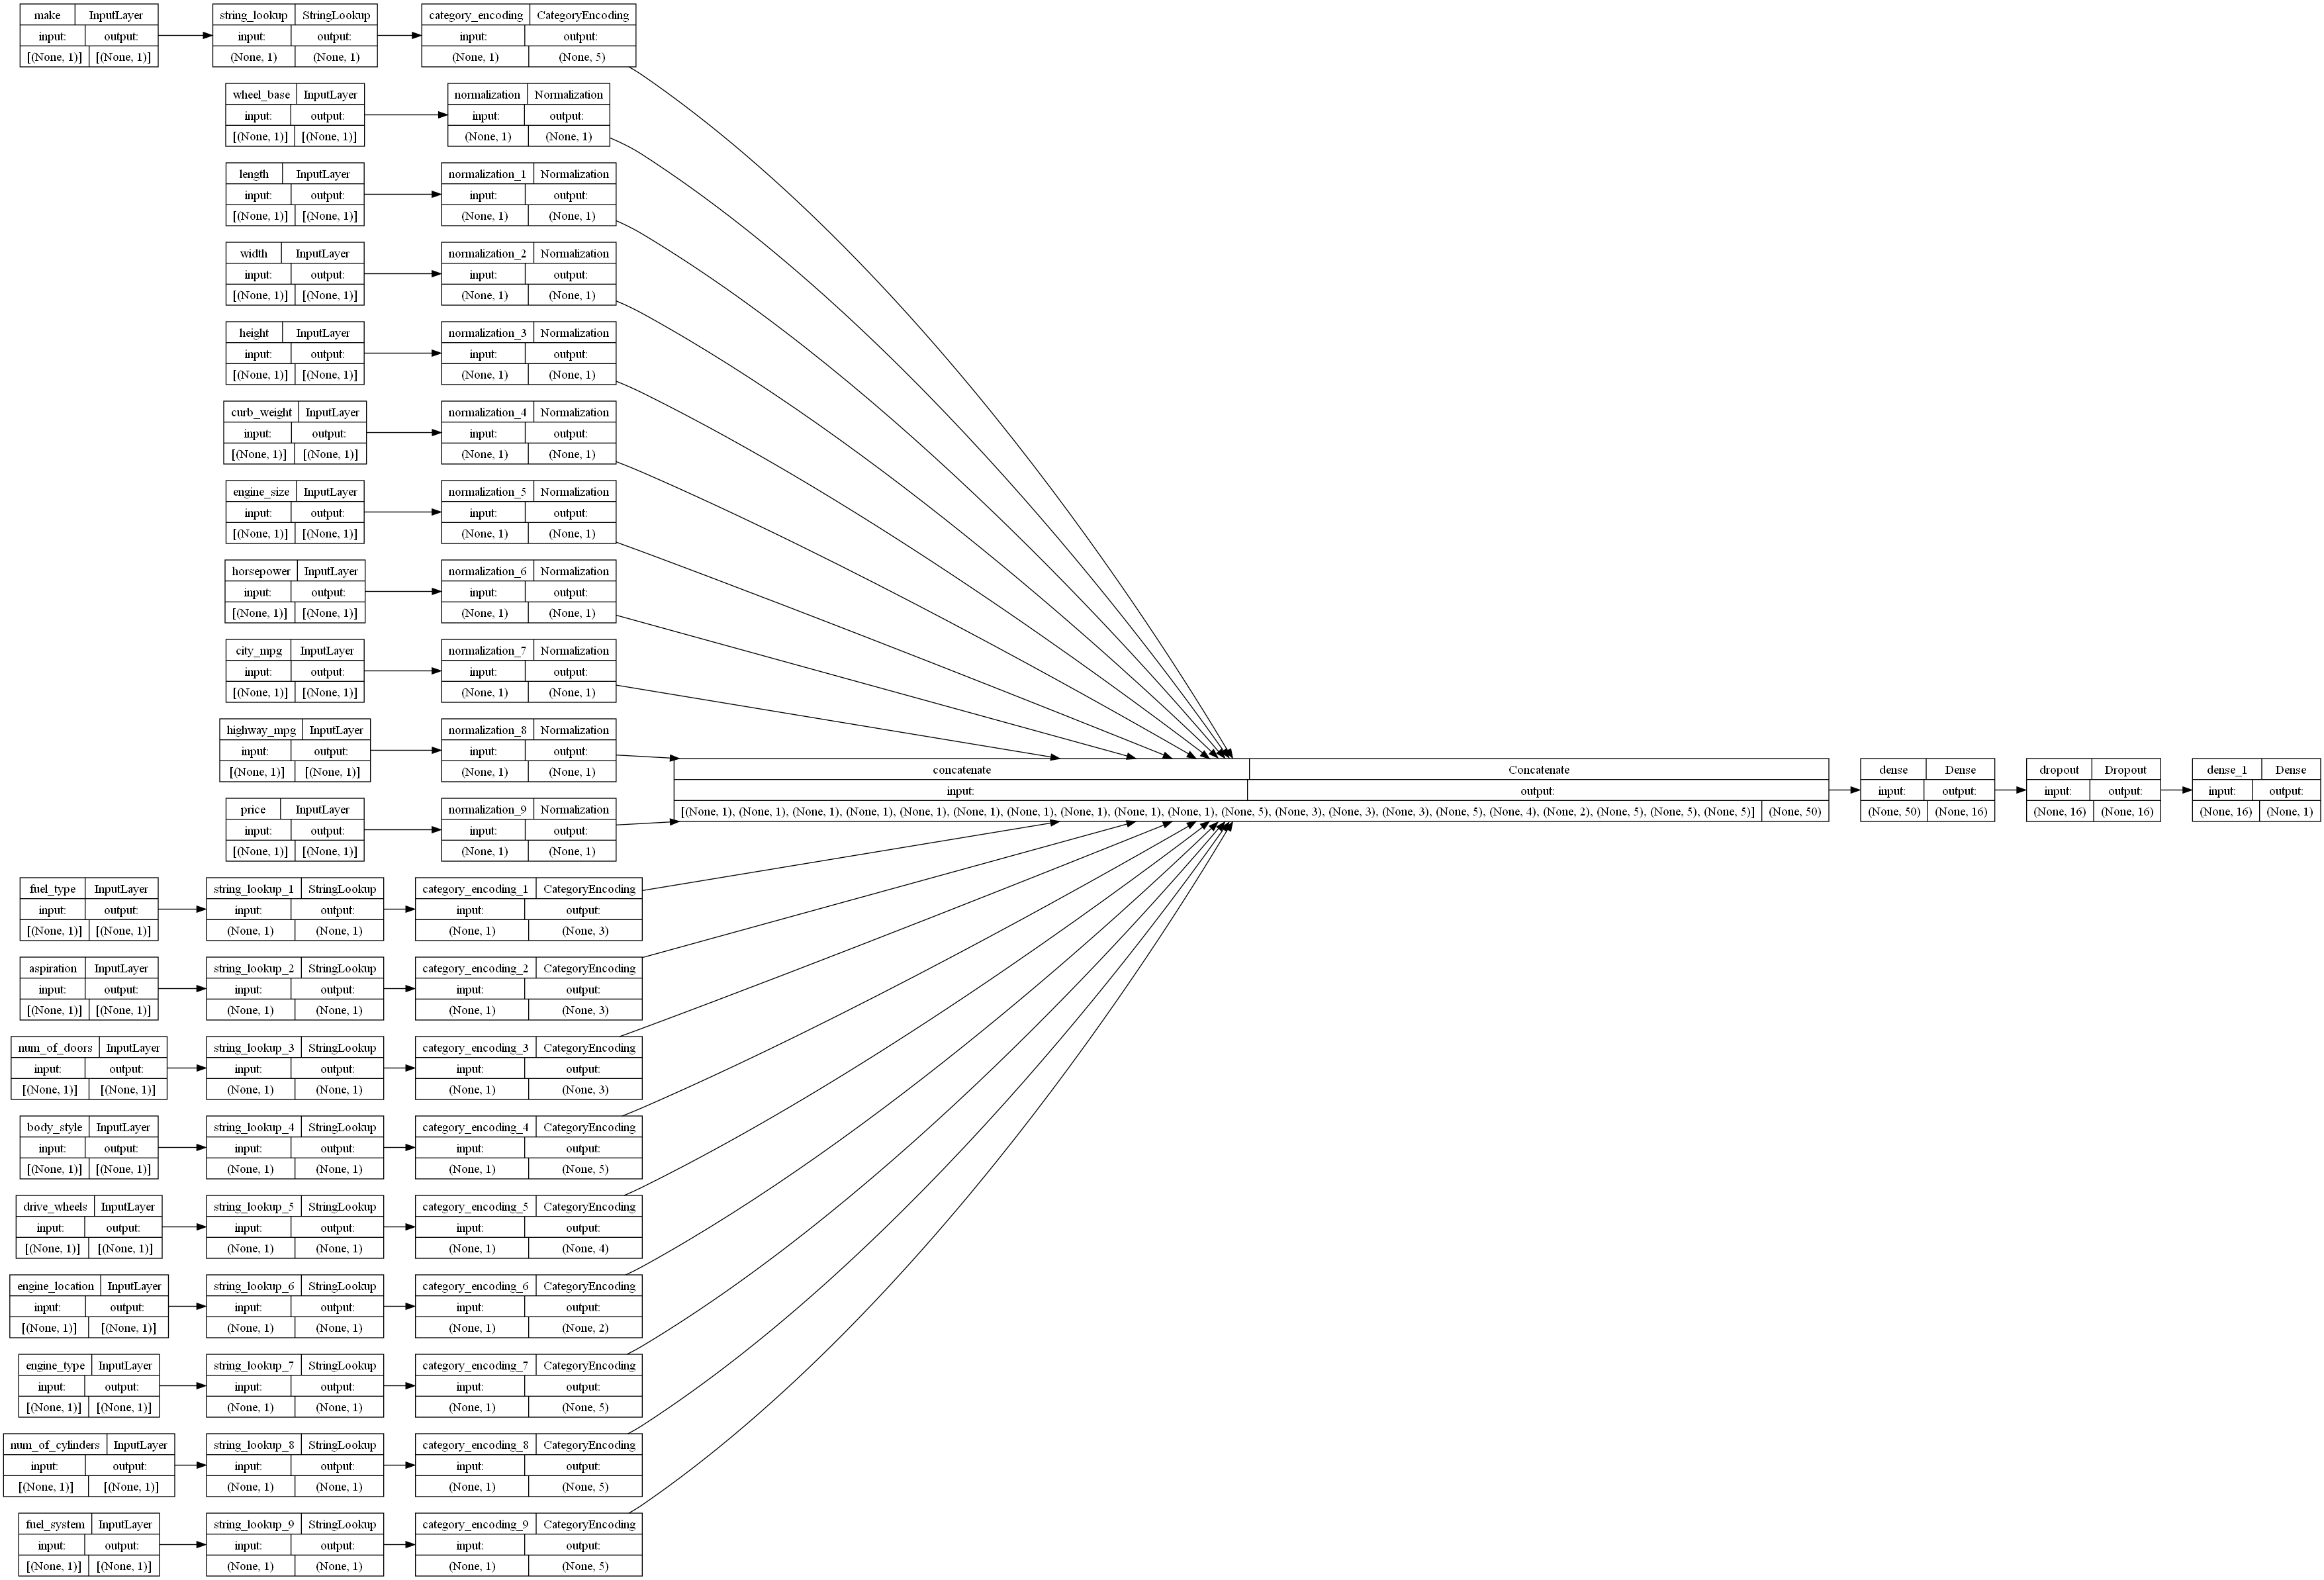

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [23]:
model.fit(tfds_train, epochs=n_epoch, validation_data=tfds_val)

Epoch 1/25


C:\Users\62896\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py:639: UserWarning: Input dict contained keys ['symboling', 'symboling_threshold'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


6/6 [==============================] - 1s 74ms/step - loss: 4.0595 - accuracy: 0.5276 - val_loss: 1.0696 - val_accuracy: 0.4375
Epoch 2/25
6/6 [==============================] - 0s 4ms/step - loss: 4.7431 - accuracy: 0.4646 - val_loss: 0.7909 - val_accuracy: 0.5000
Epoch 3/25
6/6 [==============================] - 0s 4ms/step - loss: 5.3856 - accuracy: 0.4724 - val_loss: 0.6698 - val_accuracy: 0.5000
Epoch 4/25
6/6 [==============================] - 0s 4ms/step - loss: 3.7372 - accuracy: 0.5906 - val_loss: 0.6083 - val_accuracy: 0.5625
Epoch 5/25
6/6 [==============================] - 0s 4ms/step - loss: 3.4606 - accuracy: 0.5827 - val_loss: 0.5881 - val_accuracy: 0.5625
Epoch 6/25
6/6 [==============================] - 0s 4ms/step - loss: 3.7458 - accuracy: 0.5984 - val_loss: 0.5723 - val_accuracy: 0.5625
Epoch 7/25
6/6 [==============================] - 0s 4ms/step - loss: 3.3352 - accuracy: 0.5748 - val_loss: 0.5472 - val_accuracy: 0.6250
Epoch 8/25
6/6 [============================

In [24]:
loss, accuracy = model.evaluate(tfds_test)
print("Accuracy", accuracy)
model.save(ex1ch0_model_path)

1/1 [==============================] - 0s 16ms/step - loss: 0.3676 - accuracy: 0.8125
Accuracy 0.8125


INFO:tensorflow:Assets written to: saved_models\ex1ch1_auto_classifier\assets


INFO:tensorflow:Assets written to: saved_models\ex1ch1_auto_classifier\assets


Perform evaluation from `tsdf_test`

In [25]:
loaded_model = tf.keras.models.load_model(ex1ch0_model_path)
metrics = eval_metrics(loaded_model, tfds_test, evaluation_metrics_dict)
metrics

C:\Users\62896\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py:639: UserWarning: Input dict contained keys ['symboling', 'symboling_threshold'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 0s 317ms/step


{'mae': 0.26861358, 'mse': 0.11920391, 'rmse': 0.3452592}

Perform inference from `inference_sample`

In [26]:
loaded_model.predict(inference_sample)

1/1 [==============================] - 0s 325ms/step


array([[0.884]], dtype=float32)